In [1]:
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from keras.layers.advanced_activations import PReLU, LeakyReLU
from keras.regularizers import l2
from keras.utils import np_utils
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [2]:
df = pd.read_csv('../dataset/face/fer2013.csv')
df.tail()

,emotion,pixels,Usage
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest
35886,2,19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...,PrivateTest


In [3]:
train = df[df.Usage == 'Training']
test = df[df.Usage == 'PrivateTest']
val = df[df.Usage == 'PublicTest']

In [4]:
not_face = [59, 2059, 2809, 3262, 3931,4275, 5439, 5509, 5722, 5881, 6102, 6458, 6699, 7172,
 7496, 7527, 7629, 8030, 8737, 8856, 9026, 9500, 9673, 9679, 9693, 9797, 10023,
 10423, 10657, 11244, 11286, 11295, 11846, 12289, 12352, 13011, 13148, 13402, 13697,
 13839, 13988, 14148, 14279, 15144, 15553, 15838, 15894, 16024, 16540, 17081, 17620,
 18012, 18337, 19238, 19422, 19632, 20222, 20712, 20817, 21817, 22198,
 22407, 22927, 23596, 23894, 24053, 24441, 14593, 24891, 25219, 25603, 25909, 26383,
 26860, 26897, 28601, 19447]

In [5]:
train1 = train.drop(not_face, axis=0)

In [6]:
print('train: {}'.format(len(train)))
print('train1: {}'.format(len(train1)))
print('test: {}'.format(len(test)))
print('validation: {}'.format(len(val)))

train: 28709
train1: 28632
test: 3589
validation: 3589


# Build X sets

In [7]:
def build_X(data):
    res = np.zeros((len(data), 48, 48, 1)).astype('float32')

    for i in range(len(data)):
        pixl = data.iloc[i,:].pixels.split(' ')
        pixels = np.array(pixl).astype('float32') / 255.
        pixels = pixels.reshape(48, 48, 1)
        res[i] = pixels
    
    return res

In [8]:
X_train = build_X(train)
X_train1 = build_X(train1)
X_test = build_X(test)
X_val = build_X(val)

# Build Y sets
(0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral).

In [9]:
# One Hot Encoding 7 categories
Y_train = np_utils.to_categorical(train.emotion.values, 7)
Y_train1 = np_utils.to_categorical(train1.emotion.values, 7)
Y_test = np_utils.to_categorical(test.emotion.values, 7)
Y_val = np_utils.to_categorical(val.emotion.values, 7)

In [10]:
Y_train[:3]

array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.]])

# Print Images

In [11]:
def print_img(row, col, target, idx):
    fig = plt.figure(figsize=(col*2.5, row*2.5))
    
    for i in range(len(idx)):
        plt.subplot(row, col, (i+1))
        plt.imshow(target[idx[i]].reshape((48, 48)), cmap='gray')
        plt.grid(False); plt.xticks([]); plt.yticks([]);
    
    plt.show()

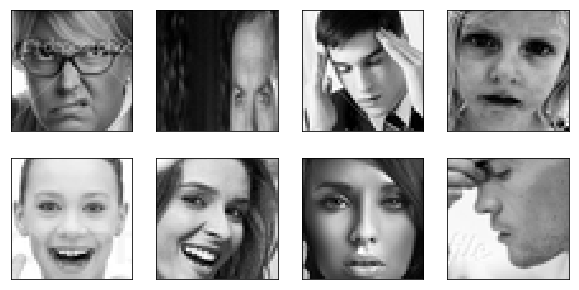

In [12]:
print_img(row=2, col=4, target=X_test, idx=[0, 1, 2, 3, 10, 11, 12, 13])

# Build Pipeline

In [11]:
model1 = keras.models.load_model("../models/face_M_s1.hdf5")

In [12]:
proba_pred = model1.predict(X_test)
Y_pred = model1.predict_classes(X_test)

3584/3589 [============================>.] - ETA: 0s

In [13]:
dfRes = pd.DataFrame(Y_pred, columns=['pred'])

In [14]:
dfRes['origin'] = test.emotion.values
dfRes['result'] = Y_pred == test.emotion.values
dfRes['p0'] = proba_pred[:, 0]
dfRes['p1'] = proba_pred[:, 1]
dfRes['p2'] = proba_pred[:, 2]
dfRes['p3'] = proba_pred[:, 3]
dfRes['p4'] = proba_pred[:, 4]
dfRes['p5'] = proba_pred[:, 5]
dfRes['p6'] = proba_pred[:, 6]

In [15]:
dfRes.head(10)

,pred,origin,result,p0,p1,p2,p3,p4,p5,p6
0,1,0,False,0.031025,9.249825e-01,0.021350,0.000021,0.021445,0.000438,0.000739
1,4,5,False,0.122550,3.189882e-03,0.116838,0.008866,0.689354,0.002836,0.056367
2,2,6,False,0.037250,4.269669e-04,0.891100,0.000153,0.068474,0.001894,0.000702
3,4,4,True,0.222432,4.796853e-02,0.059570,0.000398,0.602916,0.001248,0.065468
4,0,2,False,0.282585,2.662550e-01,0.192798,0.000271,0.098072,0.139780,0.020239
5,0,0,True,0.651639,1.696520e-02,0.307104,0.000236,0.021952,0.001842,0.000262
6,2,4,False,0.045593,6.206274e-05,0.507899,0.019260,0.208117,0.001534,0.217536
7,3,3,True,0.000001,2.448323e-10,0.000002,0.999924,0.000001,0.000014,0.000058
8,3,0,False,0.094211,1.841337e-02,0.143292,0.482603,0.024179,0.145674,0.091627
9,3,3,True,0.013017,1.242004e-04,0.001324,0.973209,0.001321,0.007692,0.003312


In [16]:
# Total Accuracy
acc = float((dfRes['result'] == True).sum()) / len(dfRes['result'])
acc

0.6349958205628309

In [17]:
idx_train = pd.DataFrame(train.emotion.values, columns=['label'])
idx_test = pd.DataFrame(test.emotion.values, columns=['label'])

# Model7 (Angry : Disgust : Fear : Sad : Neutral)

In [225]:
X_train7 = np.vstack((X_train[idx_train[idx_train['label'] == 0].index], X_train[idx_train[idx_train['label'] == 1].index], X_train[idx_train[idx_train['label'] == 2].index], X_train[idx_train[idx_train['label'] == 4].index], X_train[idx_train[idx_train['label'] == 6].index]))
Y_train7 = np.vstack((Y_train[idx_train[idx_train['label'] == 0].index], Y_train[idx_train[idx_train['label'] == 1].index], Y_train[idx_train[idx_train['label'] == 2].index], Y_train[idx_train[idx_train['label'] == 4].index], Y_train[idx_train[idx_train['label'] == 6].index]))[:,[0,1,2,4,6]]

X_test7 = np.vstack((X_test[idx_test[idx_test['label'] == 0].index], X_test[idx_test[idx_test['label'] == 1].index], X_test[idx_test[idx_test['label'] == 2].index], X_test[idx_test[idx_test['label'] == 4].index], X_test[idx_test[idx_test['label'] == 6].index]))
Y_test7 = np.vstack((Y_test[idx_test[idx_test['label'] == 0].index], Y_test[idx_test[idx_test['label'] == 1].index], Y_test[idx_test[idx_test['label'] == 2].index], Y_test[idx_test[idx_test['label'] == 4].index], Y_test[idx_test[idx_test['label'] == 6].index]))[:,[0,1,2,4,6]]

In [226]:
print('X_train: {}'.format(X_train7.shape))
print('Y_train: {}'.format(Y_train7.shape))
print('X_test: {}'.format(X_test7.shape))
print('Y_test: {}'.format(Y_test7.shape))

X_train: (18323, 48, 48, 1)
Y_train: (18323, 5)
X_test: (2294, 48, 48, 1)
Y_test: (2294, 5)


In [238]:
Y_train7

array([[ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  1.]])

In [229]:
np.random.seed(0)

model07 = Sequential()

model07.add(Conv2D(64, (5, 5), activation='relu', input_shape=(48, 48, 1), padding='same', kernel_regularizer=l2(0.001)))
model07.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
model07.add(MaxPooling2D())
model07.add(Dropout(0.3))

model07.add(Conv2D(128, (5, 5), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model07.add(Conv2D(128, (5, 5), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model07.add(MaxPooling2D())
model07.add(Dropout(0.4))

model07.add(Conv2D(256, (5, 5), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model07.add(Conv2D(256, (5, 5), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model07.add(MaxPooling2D())
model07.add(Dropout(0.4))

model07.add(Flatten())
model07.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))
model07.add(Dropout(0.5))
model07.add(Dense(5, activation='softmax'))

opt = optimizers.Adadelta()
model07.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [231]:
%%time
hist07 = model07.fit(X_train7, Y_train7, epochs=50, batch_size=100, validation_data=(X_test7, Y_test7), verbose=2)

Train on 18323 samples, validate on 2294 samples
Epoch 1/50
38s - loss: 1.2350 - acc: 0.5361 - val_loss: 1.2629 - val_acc: 0.5126
Epoch 2/50
38s - loss: 1.2246 - acc: 0.5412 - val_loss: 1.2710 - val_acc: 0.4943
Epoch 3/50
39s - loss: 1.2131 - acc: 0.5511 - val_loss: 1.3315 - val_acc: 0.4891
Epoch 4/50
39s - loss: 1.2102 - acc: 0.5573 - val_loss: 1.4210 - val_acc: 0.4612
Epoch 5/50
39s - loss: 1.2026 - acc: 0.5656 - val_loss: 1.2890 - val_acc: 0.5131
Epoch 6/50
39s - loss: 1.1884 - acc: 0.5714 - val_loss: 1.3423 - val_acc: 0.4804
Epoch 7/50
39s - loss: 1.1810 - acc: 0.5753 - val_loss: 1.3032 - val_acc: 0.5144
Epoch 8/50
39s - loss: 1.1727 - acc: 0.5860 - val_loss: 1.3166 - val_acc: 0.5026
Epoch 9/50
39s - loss: 1.1616 - acc: 0.5931 - val_loss: 1.3269 - val_acc: 0.5070
Epoch 10/50
39s - loss: 1.1471 - acc: 0.6050 - val_loss: 1.3396 - val_acc: 0.5052
Epoch 11/50
39s - loss: 1.1430 - acc: 0.6105 - val_loss: 1.4058 - val_acc: 0.5166
Epoch 12/50
39s - loss: 1.1324 - acc: 0.6174 - val_loss: 1

In [232]:
model07.save("../models/face_M07.hdf5")

# Model 8(Angry : All)

In [31]:
Y_train_rmfo = np_utils.to_categorical((train.emotion.values != 0).astype(int), 2)
Y_test_rmfo = np_utils.to_categorical((test.emotion.values != 0).astype(int), 2)
Y_val_rmfo = np_utils.to_categorical((val.emotion.values != 0).astype(int), 2)

In [32]:
Y_train_rmfo[:5]

array([[ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.]])

In [43]:
np.random.seed(0)

model08 = Sequential()

model08.add(Conv2D(64, (5, 5), activation='relu', input_shape=(48, 48, 1), padding='same', kernel_regularizer=l2(0.001)))
model08.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
model08.add(MaxPooling2D())
model08.add(Dropout(0.3))

model08.add(Conv2D(128, (5, 5), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model08.add(Conv2D(128, (5, 5), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model08.add(MaxPooling2D())
model08.add(Dropout(0.4))

model08.add(Conv2D(256, (5, 5), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model08.add(Conv2D(256, (5, 5), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model08.add(MaxPooling2D())
model08.add(Dropout(0.4))

model08.add(Flatten())
model08.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))
model08.add(Dropout(0.5))
model08.add(Dense(2, activation='softmax'))

opt = optimizers.Adadelta()
model08.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [44]:
%%time
hist08 = model08.fit(X_train, Y_train_rmfo, epochs=50, batch_size=100, validation_data=(X_test, Y_test_rmfo), verbose=2)

Train on 28709 samples, validate on 3589 samples
Epoch 1/50
58s - loss: 1.4595 - acc: 0.8588 - val_loss: 1.0188 - val_acc: 0.8632
Epoch 2/50
57s - loss: 0.7556 - acc: 0.8608 - val_loss: 0.5993 - val_acc: 0.8632
Epoch 3/50
57s - loss: 0.5206 - acc: 0.8608 - val_loss: 0.4641 - val_acc: 0.8632
Epoch 4/50
57s - loss: 0.4424 - acc: 0.8608 - val_loss: 0.4571 - val_acc: 0.8632
Epoch 5/50
57s - loss: 0.4147 - acc: 0.8608 - val_loss: 0.4243 - val_acc: 0.8632
Epoch 6/50
57s - loss: 0.4024 - acc: 0.8608 - val_loss: 0.4091 - val_acc: 0.8632
Epoch 7/50
57s - loss: 0.3962 - acc: 0.8608 - val_loss: 0.3970 - val_acc: 0.8632
Epoch 8/50


KeyboardInterrupt: 

# Model9 (Angry : Fear : Sad : Neutral)

In [33]:
X_train9 = np.vstack((X_train[idx_train[idx_train['label'] == 0].index], X_train[idx_train[idx_train['label'] == 2].index], X_train[idx_train[idx_train['label'] == 4].index], X_train[idx_train[idx_train['label'] == 6].index]))
Y_train9 = np.vstack((Y_train[idx_train[idx_train['label'] == 0].index], Y_train[idx_train[idx_train['label'] == 2].index], Y_train[idx_train[idx_train['label'] == 4].index], Y_train[idx_train[idx_train['label'] == 6].index]))[:,[0,2,4,6]]

X_test9 = np.vstack((X_test[idx_test[idx_test['label'] == 0].index], X_test[idx_test[idx_test['label'] == 2].index], X_test[idx_test[idx_test['label'] == 4].index], X_test[idx_test[idx_test['label'] == 6].index]))
Y_test9 = np.vstack((Y_test[idx_test[idx_test['label'] == 0].index], Y_test[idx_test[idx_test['label'] == 2].index], Y_test[idx_test[idx_test['label'] == 4].index], Y_test[idx_test[idx_test['label'] == 6].index]))[:,[0,2,4,6]]

In [35]:
print('X_train: {}'.format(X_train9.shape))
print('Y_train: {}'.format(Y_train9.shape))
print('X_test: {}'.format(X_test9.shape))
print('Y_test: {}'.format(Y_test9.shape))

X_train: (17887, 48, 48, 1)
Y_train: (17887, 4)
X_test: (2239, 48, 48, 1)
Y_test: (2239, 4)


In [36]:
Y_train9

array([[ 1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  1.]])

In [37]:
np.random.seed(0)

model09 = Sequential()

model09.add(Conv2D(64, (5, 5), activation='relu', input_shape=(48, 48, 1), padding='same', kernel_regularizer=l2(0.001)))
model09.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
model09.add(MaxPooling2D())
model09.add(Dropout(0.3))

model09.add(Conv2D(128, (5, 5), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model09.add(Conv2D(128, (5, 5), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model09.add(MaxPooling2D())
model09.add(Dropout(0.4))

model09.add(Conv2D(256, (5, 5), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model09.add(Conv2D(256, (5, 5), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model09.add(MaxPooling2D())
model09.add(Dropout(0.4))

model09.add(Flatten())
model09.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))
model09.add(Dropout(0.5))
model09.add(Dense(4, activation='softmax'))

opt = optimizers.Adadelta()
model09.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [38]:
%%time
hist09 = model09.fit(X_train9, Y_train9, epochs=50, batch_size=100, validation_data=(X_test9, Y_test9), verbose=2)

Train on 17887 samples, validate on 2239 samples
Epoch 1/50
39s - loss: 2.5593 - acc: 0.2762 - val_loss: 2.1876 - val_acc: 0.2760
Epoch 2/50
35s - loss: 1.9628 - acc: 0.2915 - val_loss: 1.7767 - val_acc: 0.3109
Epoch 3/50
35s - loss: 1.6651 - acc: 0.3223 - val_loss: 1.5682 - val_acc: 0.3430
Epoch 4/50
35s - loss: 1.5129 - acc: 0.3361 - val_loss: 1.4530 - val_acc: 0.3631
Epoch 5/50
35s - loss: 1.4289 - acc: 0.3613 - val_loss: 1.3882 - val_acc: 0.3899
Epoch 6/50
35s - loss: 1.3805 - acc: 0.3772 - val_loss: 1.3867 - val_acc: 0.3711
Epoch 7/50
35s - loss: 1.3521 - acc: 0.3939 - val_loss: 1.3133 - val_acc: 0.4176
Epoch 8/50
35s - loss: 1.3284 - acc: 0.4107 - val_loss: 1.3046 - val_acc: 0.4292
Epoch 9/50
35s - loss: 1.3118 - acc: 0.4196 - val_loss: 1.2880 - val_acc: 0.4314
Epoch 10/50
35s - loss: 1.2980 - acc: 0.4335 - val_loss: 1.2850 - val_acc: 0.4422
Epoch 11/50
35s - loss: 1.2800 - acc: 0.4500 - val_loss: 1.2715 - val_acc: 0.4569
Epoch 12/50
35s - loss: 1.2648 - acc: 0.4684 - val_loss: 1

In [39]:
model09.save("../models/face_M09.hdf5")

# Model 11 (Happy vs Surprise vs Others)

In [211]:
temp = train.emotion.values.copy()

In [195]:
Y_train_temp = train.emotion.values
Y_train_temp[temp == 3] = 0 # Happy
Y_train_temp[temp == 5] = 1 # Surprise
Y_train_temp[(temp == 0) | (temp== 1) | (temp == 2) | (temp== 4) | (temp == 6)] = 2 # Angry, Fear, Sad, Neutral

In [206]:
Y_train_temp[:20]

array([2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 0, 1, 0, 2, 2, 2])

In [208]:
temp = test.emotion.values.copy()

In [209]:
Y_test_temp = test.emotion.values
Y_test_temp[temp == 3] = 0 # Happy
Y_test_temp[temp == 5] = 1 # Surprise
Y_test_temp[(temp == 0) | (temp== 1) | (temp == 2) | (temp== 4) | (temp == 6)] = 2 # Angry, Fear, Sad, Neutral

In [210]:
Y_test_temp[:20]

array([2, 1, 2, 2, 2, 2, 2, 0, 2, 0, 1, 0, 2, 2, 2, 2, 2, 1, 2, 2])

In [217]:
Y_train11 = np_utils.to_categorical(Y_train_temp, 3)
Y_test11 = np_utils.to_categorical(Y_test_temp, 3)

In [218]:
Y_train11.shape

(28709, 3)

In [219]:
Y_test11.shape

(3589, 3)

In [222]:
np.random.seed(0)

model11 = Sequential()

model11.add(Conv2D(64, (5, 5), activation='relu', input_shape=(48, 48, 1), padding='same', kernel_regularizer=l2(0.001)))
model11.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
model11.add(MaxPooling2D())
model11.add(Dropout(0.3))

model11.add(Conv2D(128, (5, 5), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model11.add(Conv2D(128, (5, 5), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model11.add(MaxPooling2D())
model11.add(Dropout(0.4))

model11.add(Conv2D(256, (5, 5), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model11.add(Conv2D(256, (5, 5), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model11.add(MaxPooling2D())
model11.add(Dropout(0.4))

model11.add(Flatten())
model11.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))
model11.add(Dropout(0.5))
model11.add(Dense(3, activation='softmax'))

opt = optimizers.Adadelta()
model11.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [225]:
%%time
hist11 = model11.fit(X_train, Y_train11, epochs=50, batch_size=100, validation_data=(X_test, Y_test11), verbose=2)

Train on 28709 samples, validate on 3589 samples
Epoch 1/50
57s - loss: 1.3308 - acc: 0.6382 - val_loss: 1.1099 - val_acc: 0.6392
Epoch 2/50
57s - loss: 0.9569 - acc: 0.6584 - val_loss: 0.9965 - val_acc: 0.6439
Epoch 3/50
57s - loss: 0.7259 - acc: 0.7475 - val_loss: 0.6373 - val_acc: 0.7790
Epoch 4/50
57s - loss: 0.6188 - acc: 0.7890 - val_loss: 0.6612 - val_acc: 0.7710
Epoch 5/50
57s - loss: 0.5623 - acc: 0.8094 - val_loss: 0.6948 - val_acc: 0.7459
Epoch 6/50
57s - loss: 0.5352 - acc: 0.8232 - val_loss: 0.5838 - val_acc: 0.7966
Epoch 7/50
57s - loss: 0.5117 - acc: 0.8336 - val_loss: 0.5236 - val_acc: 0.8303
Epoch 8/50
57s - loss: 0.4961 - acc: 0.8415 - val_loss: 0.5697 - val_acc: 0.8105
Epoch 9/50
57s - loss: 0.4804 - acc: 0.8485 - val_loss: 0.8070 - val_acc: 0.6826
Epoch 10/50
57s - loss: 0.4661 - acc: 0.8566 - val_loss: 0.5153 - val_acc: 0.8367
Epoch 11/50
57s - loss: 0.4580 - acc: 0.8608 - val_loss: 0.5067 - val_acc: 0.8378
Epoch 12/50
57s - loss: 0.4471 - acc: 0.8647 - val_loss: 0

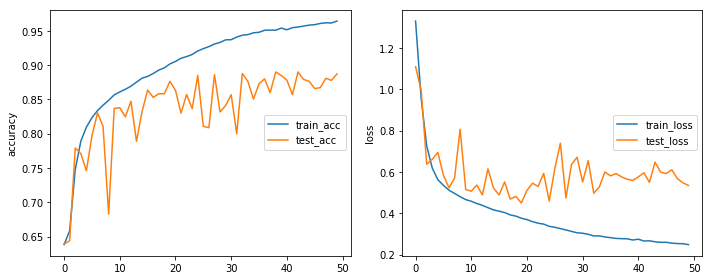

In [227]:
fig = plt.figure(figsize=(10, 4))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(hist11.history["acc"], label='train_acc')
ax1.plot(hist11.history["val_acc"], label='test_acc')
ax1.set_ylabel('accuracy')
ax1.legend(loc='center right')

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(hist11.history["loss"], label='train_loss')
ax2.plot(hist11.history["val_loss"], label='test_loss')
ax2.set_ylabel('loss')
ax2.legend(loc='center right')

fig.tight_layout()
plt.show()

In [226]:
model11.save("../models/face_M11.hdf5")

In [228]:
model11 = keras.models.load_model("../models/face_M11.hdf5")

In [246]:
proba_pred = model11.predict(X_test)
Y_pred = model11.predict_classes(X_test)

3584/3589 [============================>.] - ETA: 0s

In [247]:
dfRes1 = pd.DataFrame(Y_pred, columns=['pred'])
dfRes1['origin'] = test.emotion.values
dfRes1['result'] = Y_pred == Y_test_temp
dfRes1['p0'] = proba_pred[:, 0]
dfRes1['p1'] = proba_pred[:, 1]
dfRes1['p2'] = proba_pred[:, 2]

In [249]:
dfRes10 = dfRes1.loc[dfRes1['origin'] == 0]
dfRes11 = dfRes1.loc[dfRes1['origin'] == 1]
dfRes12 = dfRes1.loc[dfRes1['origin'] == 2]

In [250]:
acc0 = float((dfRes10['result'] == True).sum()) / len(dfRes10['result'])
acc1 = float((dfRes11['result'] == True).sum()) / len(dfRes11['result'])
acc2 = float((dfRes12['result'] == True).sum()) / len(dfRes12['result'])

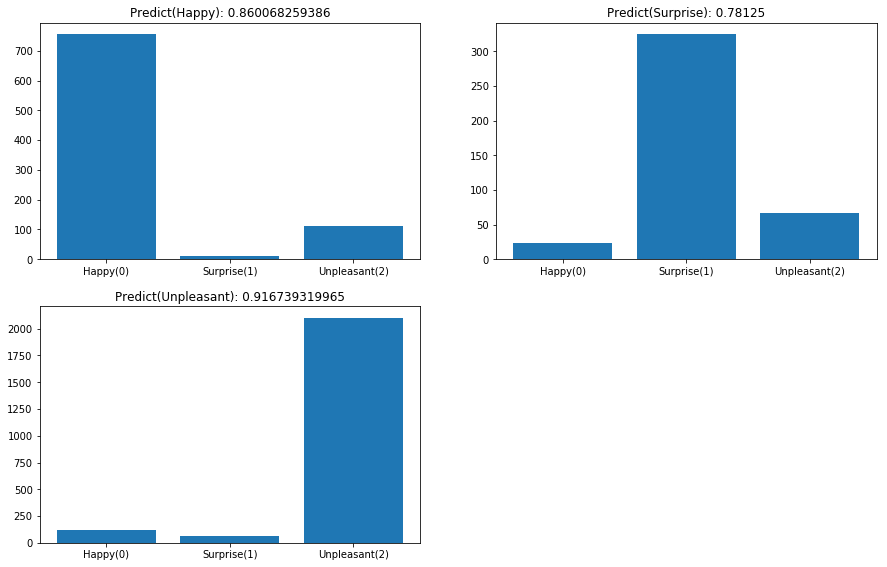

In [252]:
plt.figure(figsize=(15, 20))
res = [dfRes10, dfRes11, dfRes12]
title = ['Happy', 'Surprise', 'Unpleasant']
acc_li = [acc0, acc1, acc2]
x = [0, 1, 2]

for i in range(len(res)):
    plt.subplot(4, 2, (i+1))
    y = []

    for j in range(3):
        y.append((res[i]['pred'] == j).sum())
        
    plt.bar(left=x, height=y)
    plt.xticks(x, ['Happy(0)', 'Surprise(1)', 'Unpleasant(2)'])
    plt.title('Predict({}): {}'.format(title[i], acc_li[i]))

plt.show()

# Model12

In [18]:
np.random.seed(10)

model1 = Sequential()

model1.add(Conv2D(64, (5, 5), activation='relu', input_shape=(48, 48, 1), padding='same', kernel_regularizer=l2(0.001)))
model1.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
model1.add(MaxPooling2D())
model1.add(Dropout(0.5))

model1.add(Conv2D(128, (5, 5), activation=PReLU(), padding='same', kernel_regularizer=l2(0.001)))
model1.add(Conv2D(128, (5, 5), activation=PReLU(), padding='same', kernel_regularizer=l2(0.001)))
model1.add(MaxPooling2D())
model1.add(Dropout(0.5))

model1.add(Conv2D(128, (5, 5), activation=PReLU(), padding='same', kernel_regularizer=l2(0.001)))
model1.add(Conv2D(128, (5, 5), activation=PReLU(), padding='same', kernel_regularizer=l2(0.001)))
model1.add(MaxPooling2D())
model1.add(Dropout(0.5))

model1.add(Conv2D(256, (5, 5), activation=PReLU(), padding='same', kernel_regularizer=l2(0.001)))
model1.add(Conv2D(256, (5, 5), activation=PReLU(), padding='same', kernel_regularizer=l2(0.001)))
model1.add(MaxPooling2D())
model1.add(Dropout(0.5))

model1.add(Flatten())
model1.add(Dense(512, activation=PReLU(), kernel_regularizer=l2(0.001)))
model1.add(Dropout(0.5))
model1.add(Dense(7, activation='softmax'))

opt = optimizers.Adadelta()
model1.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
%%time
hist1 = model1.fit(X_train, Y_train, epochs=100, batch_size=100, validation_data=(X_test, Y_test), verbose=2)

Train on 28709 samples, validate on 3589 samples
Epoch 1/100
68s - loss: 3.0376 - acc: 0.2433 - val_loss: 2.5311 - val_acc: 0.2449
Epoch 2/100


In [159]:
model1.save("../models/face_M_s11.hdf5")

AttributeError: 'PReLU' object has no attribute '__name__'

In [144]:
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 48, 48, 64)        1664      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 48, 48, 64)        102464    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 128)       409728    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 128)       0         
__________

# Model13

In [16]:
np.random.seed(0)

model2 = Sequential()

model2.add(Conv2D(64, (5, 5), input_shape=(48, 48, 1), padding='same', kernel_regularizer=l2(0.001)))
model2.add(LeakyReLU(alpha=0.3))
model2.add(Conv2D(64, (5, 5), padding='same'))
model2.add(LeakyReLU(alpha=0.3))
model2.add(MaxPooling2D())
model2.add(Dropout(0.5))

model2.add(Conv2D(128, (5, 5), padding='same', kernel_regularizer=l2(0.001)))
model2.add(LeakyReLU(alpha=0.3))
model2.add(Conv2D(128, (5, 5), padding='same', kernel_regularizer=l2(0.001)))
model2.add(LeakyReLU(alpha=0.3))
model2.add(MaxPooling2D())
model2.add(Dropout(0.5))

model2.add(Conv2D(128, (5, 5), padding='same', kernel_regularizer=l2(0.001)))
model2.add(LeakyReLU(alpha=0.3))
model2.add(Conv2D(128, (5, 5), padding='same', kernel_regularizer=l2(0.001)))
model2.add(LeakyReLU(alpha=0.3))
model2.add(MaxPooling2D())
model2.add(Dropout(0.5))

model2.add(Conv2D(256, (5, 5), padding='same', kernel_regularizer=l2(0.001)))
model2.add(LeakyReLU(alpha=0.3))
model2.add(Conv2D(256, (5, 5), padding='same', kernel_regularizer=l2(0.001)))
model2.add(LeakyReLU(alpha=0.3))
model2.add(MaxPooling2D())
model2.add(Dropout(0.5))

model2.add(Flatten())
model2.add(Dense(512, kernel_regularizer=l2(0.001)))
model2.add(LeakyReLU(alpha=0.3))
model2.add(Dropout(0.5))
model2.add(Dense(7, activation='softmax'))

opt = optimizers.Adadelta()
model2.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [16]:
%%time
hist2 = model2.fit(X_train1, Y_train1, epochs=200, batch_size=100, validation_data=(X_test, Y_test), verbose=2)

Train on 28632 samples, validate on 3589 samples
Epoch 1/200
71s - loss: 3.0734 - acc: 0.2414 - val_loss: 2.5589 - val_acc: 0.2449
Epoch 2/200
70s - loss: 2.2715 - acc: 0.2507 - val_loss: 2.0782 - val_acc: 0.2463
Epoch 3/200
70s - loss: 1.9675 - acc: 0.2557 - val_loss: 1.8880 - val_acc: 0.2446
Epoch 4/200
70s - loss: 1.8096 - acc: 0.2997 - val_loss: 1.6797 - val_acc: 0.3761
Epoch 5/200


KeyboardInterrupt: 

In [133]:
model2.save("../models/face_M_s3.hdf5")

In [17]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 48, 48, 64)        1664      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 48, 48, 64)        102464    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 24, 24, 128)       204928    
__________

# Model14

In [72]:
np.random.seed(0)

model3 = Sequential()

model3.add(Conv2D(64, (5, 5), input_shape=(48, 48, 1), padding='same', kernel_regularizer=l2(0.001)))
model3.add(PReLU(alpha_initializer='zeros'))
model3.add(Conv2D(64, (5, 5), padding='same'))
model3.add(PReLU(alpha_initializer='zeros'))
model3.add(MaxPooling2D())
model3.add(Dropout(0.5))

model3.add(Conv2D(128, (5, 5), padding='same', kernel_regularizer=l2(0.001)))
model3.add(PReLU(alpha_initializer='zeros'))
model3.add(Conv2D(128, (5, 5), padding='same', kernel_regularizer=l2(0.001)))
model3.add(PReLU(alpha_initializer='zeros'))
model3.add(MaxPooling2D())
model3.add(Dropout(0.5))

model3.add(Conv2D(128, (5, 5), padding='same', kernel_regularizer=l2(0.001)))
model3.add(PReLU(alpha_initializer='zeros'))
model3.add(Conv2D(128, (5, 5), padding='same', kernel_regularizer=l2(0.001)))
model3.add(PReLU(alpha_initializer='zeros'))
model3.add(MaxPooling2D())
model3.add(Dropout(0.5))

model3.add(Conv2D(256, (5, 5), padding='same', kernel_regularizer=l2(0.001)))
model3.add(PReLU(alpha_initializer='zeros'))
model3.add(Conv2D(256, (5, 5), padding='same', kernel_regularizer=l2(0.001)))
model3.add(PReLU(alpha_initializer='zeros'))
model3.add(MaxPooling2D())
model3.add(Dropout(0.5))

model3.add(Flatten())
model3.add(Dense(512, kernel_regularizer=l2(0.001)))
model3.add(PReLU(alpha_initializer='zeros'))
model3.add(Dropout(0.5))
model3.add(Dense(7, activation='softmax'))

opt = optimizers.Adadelta()
model3.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [73]:
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_80 (Conv2D)           (None, 48, 48, 64)        1664      
_________________________________________________________________
p_re_lu_84 (PReLU)           (None, 48, 48, 64)        147456    
_________________________________________________________________
conv2d_81 (Conv2D)           (None, 48, 48, 64)        102464    
_________________________________________________________________
p_re_lu_85 (PReLU)           (None, 48, 48, 64)        147456    
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_46 (Dropout)         (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 24, 24, 128)       204928    
__________

In [74]:
%%time
hist3 = model3.fit(X_train1, Y_train1, epochs=200, batch_size=100, validation_data=(X_test, Y_test), verbose=2)

Train on 28632 samples, validate on 3589 samples
Epoch 1/200
74s - loss: 2.9865 - acc: 0.2427 - val_loss: 2.4855 - val_acc: 0.2449
Epoch 2/200
73s - loss: 2.2237 - acc: 0.2513 - val_loss: 2.0396 - val_acc: 0.2449
Epoch 3/200
73s - loss: 1.9516 - acc: 0.2500 - val_loss: 1.8820 - val_acc: 0.2438
Epoch 4/200
73s - loss: 1.8508 - acc: 0.2517 - val_loss: 1.8324 - val_acc: 0.2449
Epoch 5/200
73s - loss: 1.8148 - acc: 0.2525 - val_loss: 1.8023 - val_acc: 0.2488
Epoch 6/200
73s - loss: 1.8003 - acc: 0.2529 - val_loss: 1.7896 - val_acc: 0.2480
Epoch 7/200
73s - loss: 1.7871 - acc: 0.2635 - val_loss: 1.7868 - val_acc: 0.2471
Epoch 8/200
73s - loss: 1.7434 - acc: 0.3001 - val_loss: 1.7393 - val_acc: 0.2956
Epoch 9/200
73s - loss: 1.6798 - acc: 0.3458 - val_loss: 1.6673 - val_acc: 0.3530
Epoch 10/200
73s - loss: 1.6108 - acc: 0.3877 - val_loss: 1.5649 - val_acc: 0.4126
Epoch 11/200
73s - loss: 1.5721 - acc: 0.4039 - val_loss: 1.5268 - val_acc: 0.4255
Epoch 12/200
73s - loss: 1.5353 - acc: 0.4225 -

72s - loss: 0.8921 - acc: 0.7387 - val_loss: 1.3347 - val_acc: 0.6085
Epoch 101/200
72s - loss: 0.8825 - acc: 0.7418 - val_loss: 1.3479 - val_acc: 0.6041
Epoch 102/200
73s - loss: 0.8798 - acc: 0.7397 - val_loss: 1.3649 - val_acc: 0.6166
Epoch 103/200
73s - loss: 0.8782 - acc: 0.7462 - val_loss: 1.3397 - val_acc: 0.6007
Epoch 104/200
72s - loss: 0.8808 - acc: 0.7437 - val_loss: 1.3220 - val_acc: 0.6188
Epoch 105/200
73s - loss: 0.8682 - acc: 0.7456 - val_loss: 1.3575 - val_acc: 0.6227
Epoch 106/200
72s - loss: 0.8724 - acc: 0.7485 - val_loss: 1.2830 - val_acc: 0.6174
Epoch 107/200
72s - loss: 0.8720 - acc: 0.7463 - val_loss: 1.3608 - val_acc: 0.6152
Epoch 108/200
72s - loss: 0.8715 - acc: 0.7451 - val_loss: 1.3229 - val_acc: 0.6216
Epoch 109/200
72s - loss: 0.8647 - acc: 0.7486 - val_loss: 1.3638 - val_acc: 0.6169
Epoch 110/200
72s - loss: 0.8616 - acc: 0.7512 - val_loss: 1.3013 - val_acc: 0.6222
Epoch 111/200
72s - loss: 0.8545 - acc: 0.7519 - val_loss: 1.3543 - val_acc: 0.6152
Epoch 

72s - loss: 0.7170 - acc: 0.8094 - val_loss: 1.4103 - val_acc: 0.6127
Epoch 199/200
72s - loss: 0.7123 - acc: 0.8138 - val_loss: 1.4440 - val_acc: 0.6110
Epoch 200/200
72s - loss: 0.7112 - acc: 0.8130 - val_loss: 1.5310 - val_acc: 0.6116
CPU times: user 2h 35min 37s, sys: 16min 34s, total: 2h 52min 11s
Wall time: 4h 3min 17s


In [75]:
model3.save("../models/face_M_s3.hdf5")

* ### Initializing

In [42]:
def init_pred(X):
    Y_pred = model1.predict_classes(X)
    proba_pred = model1.predict(X)

    dfP = pd.DataFrame(Y_pred, columns=['pred0'])
    dfP['pred1'] = Y_pred
    dfP['0'] = proba_pred[:, 0]
    dfP['1'] = proba_pred[:, 1]
    dfP['2'] = proba_pred[:, 2]
    dfP['3'] = proba_pred[:, 3]
    dfP['4'] = proba_pred[:, 4]
    dfP['5'] = proba_pred[:, 5]
    dfP['6'] = proba_pred[:, 6]
    
    return dfP

In [19]:
dfP = init_pred(X_test)

3589/3589 [==============================] - 2s     


In [20]:
dfP.tail()

,pred0,pred1,0,1,2,3,4,5,6
3584,6,6,0.013984,0.000111,0.065083,0.000120,0.103709,0.000774,0.816219
3585,4,4,0.117561,0.011581,0.130993,0.194362,0.502526,0.003728,0.039248
3586,3,3,0.108249,0.000154,0.057606,0.549701,0.024520,0.074275,0.185496
3587,3,3,0.010776,0.000021,0.014361,0.873818,0.031663,0.004415,0.064946
3588,4,4,0.042891,0.001845,0.290667,0.000134,0.507809,0.002227,0.154426


* ### Pipeline 6

In [21]:
model11 = keras.models.load_model("../models/face_M11.hdf5") # 1st
model07 = keras.models.load_model("../models/face_M07.hdf5") # 2nd

In [128]:
dfP = init_pred(X_test)

3584/3589 [============================>.] - ETA: 0s

In [133]:
r1 = model11.predict_classes(X_test)

3552/3589 [============================>.] - ETA: 0s

In [134]:
pred1 = np.zeros(len(r1), dtype=int)
pred1[r1 == 0] = 3
pred1[r1 == 1] = 5

In [135]:
pred1[:100]

array([0, 0, 0, 0, 0, 0, 0, 3, 0, 3, 5, 3, 0, 0, 0, 0, 0, 5, 0, 0, 3, 0, 0,
       0, 3, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       3, 0, 3, 3, 0, 0, 3, 0, 0, 0, 3, 0, 0, 0, 0, 5, 0, 0, 0, 0, 3, 5, 0,
       0, 0, 0, 5, 0, 3, 0, 0, 0, 5, 0, 5, 3, 5, 0, 3, 0, 0, 0, 3, 3, 3, 5,
       0, 0, 0, 0, 0, 5, 3, 0])

In [136]:
dfP['pred1'] = pred1

In [141]:
dfP2 = dfP.loc[np.where(r1 == 2)[0]]
dfP2

,pred0,pred1,0,1,2,3,4,5,6
0,1,0,0.031025,0.924982,0.021350,2.064812e-05,0.021445,0.000438,0.000739
1,4,0,0.122550,0.003190,0.116838,8.865876e-03,0.689354,0.002836,0.056367
2,2,0,0.037250,0.000427,0.891100,1.533847e-04,0.068474,0.001894,0.000702
3,4,0,0.222432,0.047969,0.059570,3.979919e-04,0.602916,0.001248,0.065468
4,0,0,0.282585,0.266255,0.192798,2.711944e-04,0.098072,0.139780,0.020239
5,0,0,0.651639,0.016965,0.307104,2.357264e-04,0.021952,0.001842,0.000262
6,2,0,0.045593,0.000062,0.507899,1.925978e-02,0.208117,0.001534,0.217536
8,3,0,0.094211,0.018413,0.143292,4.826029e-01,0.024179,0.145674,0.091627
12,6,0,0.006310,0.000098,0.274122,2.262046e-05,0.302519,0.003970,0.412958
13,4,0,0.031273,0.000657,0.219416,4.182806e-04,0.728898,0.002684,0.016653


In [142]:
r2 = model07.predict_classes(X_test[np.where(r1 == 2)[0]])

2240/2283 [============================>.] - ETA: 0s

In [143]:
pred2 = np.zeros(len(r2), dtype=int)
pred2[r2 == 0] = 0
pred2[r2 == 1] = 1
pred2[r2 == 2] = 2
pred2[r2 == 3] = 4
pred2[r2 == 4] = 6

In [144]:
dfP['pred1'][dfP2.index] = pred2

/usr/lib/python2.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [138]:
dfRes0 = pd.DataFrame(dfP.pred0, columns=['pred0'])
dfRes0['origin'] = test.emotion.values
dfRes0['result'] = dfP.pred0 == test.emotion.values

In [145]:
dfRes1 = pd.DataFrame(dfP.pred1, columns=['pred1'])
dfRes1['origin'] = test.emotion.values
dfRes1['result'] = dfP.pred1 == test.emotion.values

In [146]:
acc0 = float((dfRes0['result'] == True).sum()) / len(dfRes0['result'])
acc1 = float((dfRes1['result'] == True).sum()) / len(dfRes1['result'])
print('acc0: {}'.format(acc0))
print('acc1: {}'.format(acc1))

acc0: 0.634995820563
acc1: 0.624686542212


In [148]:
dfRes_0 = dfRes1.loc[dfRes1['origin'] == 0]
dfRes_1 = dfRes1.loc[dfRes1['origin'] == 1]
dfRes_2 = dfRes1.loc[dfRes1['origin'] == 2]
dfRes_3 = dfRes1.loc[dfRes1['origin'] == 3]
dfRes_4 = dfRes1.loc[dfRes1['origin'] == 4]
dfRes_5 = dfRes1.loc[dfRes1['origin'] == 5]
dfRes_6 = dfRes1.loc[dfRes1['origin'] == 6]

In [149]:
acc0 = float((dfRes_0['result'] == True).sum()) / len(dfRes_0['result'])
acc1 = float((dfRes_1['result'] == True).sum()) / len(dfRes_1['result'])
acc2 = float((dfRes_2['result'] == True).sum()) / len(dfRes_2['result'])
acc3 = float((dfRes_3['result'] == True).sum()) / len(dfRes_3['result'])
acc4 = float((dfRes_4['result'] == True).sum()) / len(dfRes_4['result'])
acc5 = float((dfRes_5['result'] == True).sum()) / len(dfRes_5['result'])
acc6 = float((dfRes_6['result'] == True).sum()) / len(dfRes_6['result'])

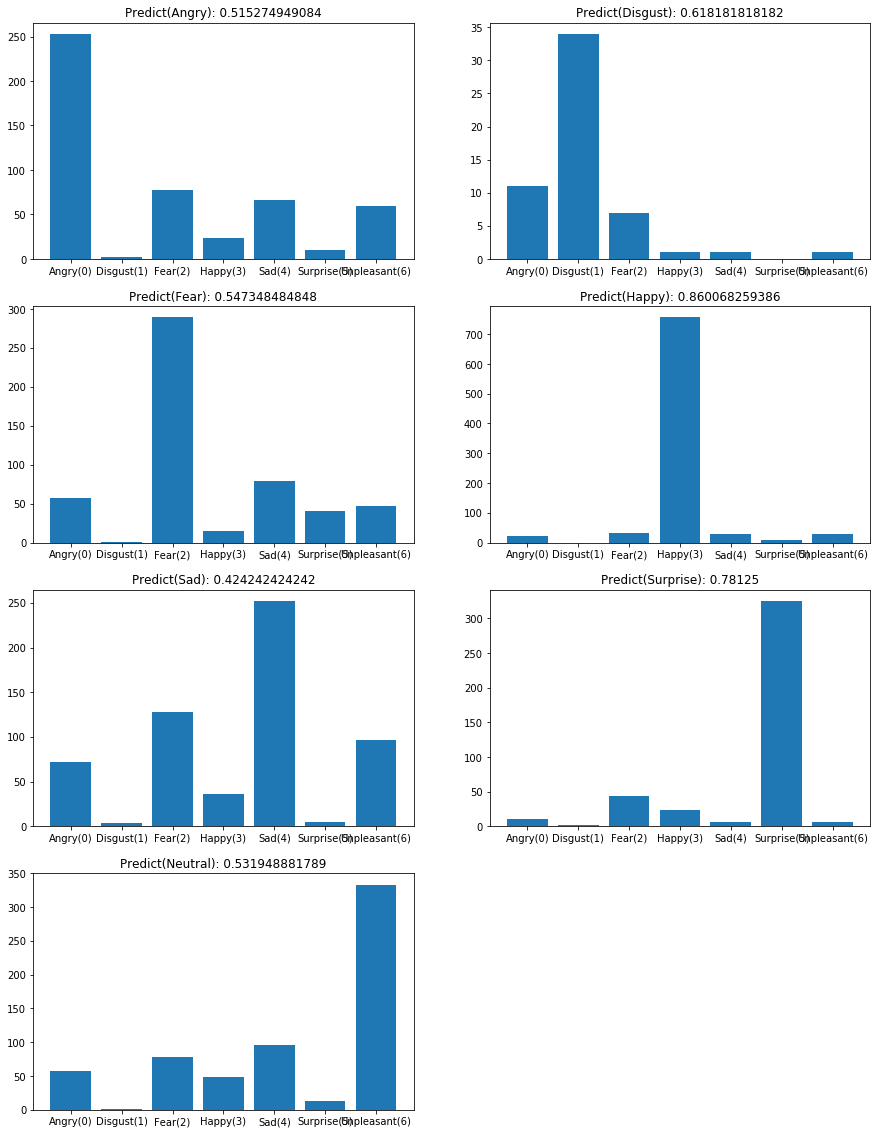

In [154]:
plt.figure(figsize=(15, 20))
res = [dfRes_0, dfRes_1, dfRes_2, dfRes_3, dfRes_4, dfRes_5, dfRes_6]
title = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
acc_li = [acc0, acc1, acc2, acc3, acc4, acc5, acc6]
x = [0, 1, 2, 3, 4, 5, 6]

for i in range(len(res)):
    plt.subplot(4, 2, (i+1))
    y = []

    for j in range(7):
        y.append((res[i]['pred1'] == j).sum())
        
    plt.bar(left=x, height=y)
    plt.xticks(x, ['Angry(0)', 'Disgust(1)', 'Fear(2)', 'Happy(3)', 'Sad(4)', 'Surprise(5)', 'Unpleasant(6)'])
    plt.title('Predict({}): {}'.format(title[i], acc_li[i]))

plt.show()

* ### Pipeline 7

In [52]:
model11 = keras.models.load_model("../models/face_M11.hdf5") # 1st
model1 = keras.models.load_model("../models/face_M_s1.hdf5") # 2nd

In [53]:
dfP = init_pred(X_test)

3589/3589 [==============================] - 3s     


In [54]:
r1 = model11.predict_classes(X_test)

3584/3589 [============================>.] - ETA: 0s

In [55]:
pred1 = np.zeros(len(r1), dtype=int)
pred1[r1 == 0] = 3
pred1[r1 == 1] = 5

In [56]:
pred1[:100]

array([0, 0, 0, 0, 0, 0, 0, 3, 0, 3, 5, 3, 0, 0, 0, 0, 0, 5, 0, 0, 3, 0, 0,
       0, 3, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       3, 0, 3, 3, 0, 0, 3, 0, 0, 0, 3, 0, 0, 0, 0, 5, 0, 0, 0, 0, 3, 5, 0,
       0, 0, 0, 5, 0, 3, 0, 0, 0, 5, 0, 5, 3, 5, 0, 3, 0, 0, 0, 3, 3, 3, 5,
       0, 0, 0, 0, 0, 5, 3, 0])

In [57]:
dfP['pred1'] = pred1

In [58]:
dfP2 = dfP.loc[np.where(r1 == 2)[0]]

In [59]:
r2 = model1.predict_classes(X_test[np.where(r1 == 2)[0]])

2272/2283 [============================>.] - ETA: 0s

In [60]:
pred2 = r2

In [61]:
dfP['pred1'][dfP2.index] = pred2

/usr/lib/python2.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [62]:
dfRes0 = pd.DataFrame(dfP.pred0, columns=['pred0'])
dfRes0['origin'] = test.emotion.values
dfRes0['result'] = dfP.pred0 == test.emotion.values

In [63]:
dfRes1 = pd.DataFrame(dfP.pred1, columns=['pred1'])
dfRes1['origin'] = test.emotion.values
dfRes1['result'] = dfP.pred1 == test.emotion.values

In [64]:
acc0 = float((dfRes0['result'] == True).sum()) / len(dfRes0['result'])
acc1 = float((dfRes1['result'] == True).sum()) / len(dfRes1['result'])
print('acc0: {}'.format(acc0))
print('acc1: {}'.format(acc1))

acc0: 0.634995820563
acc1: 0.641125661744


In [211]:
dfRes_0 = dfRes1.loc[dfRes1['origin'] == 0]
dfRes_1 = dfRes1.loc[dfRes1['origin'] == 1]
dfRes_2 = dfRes1.loc[dfRes1['origin'] == 2]
dfRes_3 = dfRes1.loc[dfRes1['origin'] == 3]
dfRes_4 = dfRes1.loc[dfRes1['origin'] == 4]
dfRes_5 = dfRes1.loc[dfRes1['origin'] == 5]
dfRes_6 = dfRes1.loc[dfRes1['origin'] == 6]

In [212]:
acc0 = float((dfRes_0['result'] == True).sum()) / len(dfRes_0['result'])
acc1 = float((dfRes_1['result'] == True).sum()) / len(dfRes_1['result'])
acc2 = float((dfRes_2['result'] == True).sum()) / len(dfRes_2['result'])
acc3 = float((dfRes_3['result'] == True).sum()) / len(dfRes_3['result'])
acc4 = float((dfRes_4['result'] == True).sum()) / len(dfRes_4['result'])
acc5 = float((dfRes_5['result'] == True).sum()) / len(dfRes_5['result'])
acc6 = float((dfRes_6['result'] == True).sum()) / len(dfRes_6['result'])

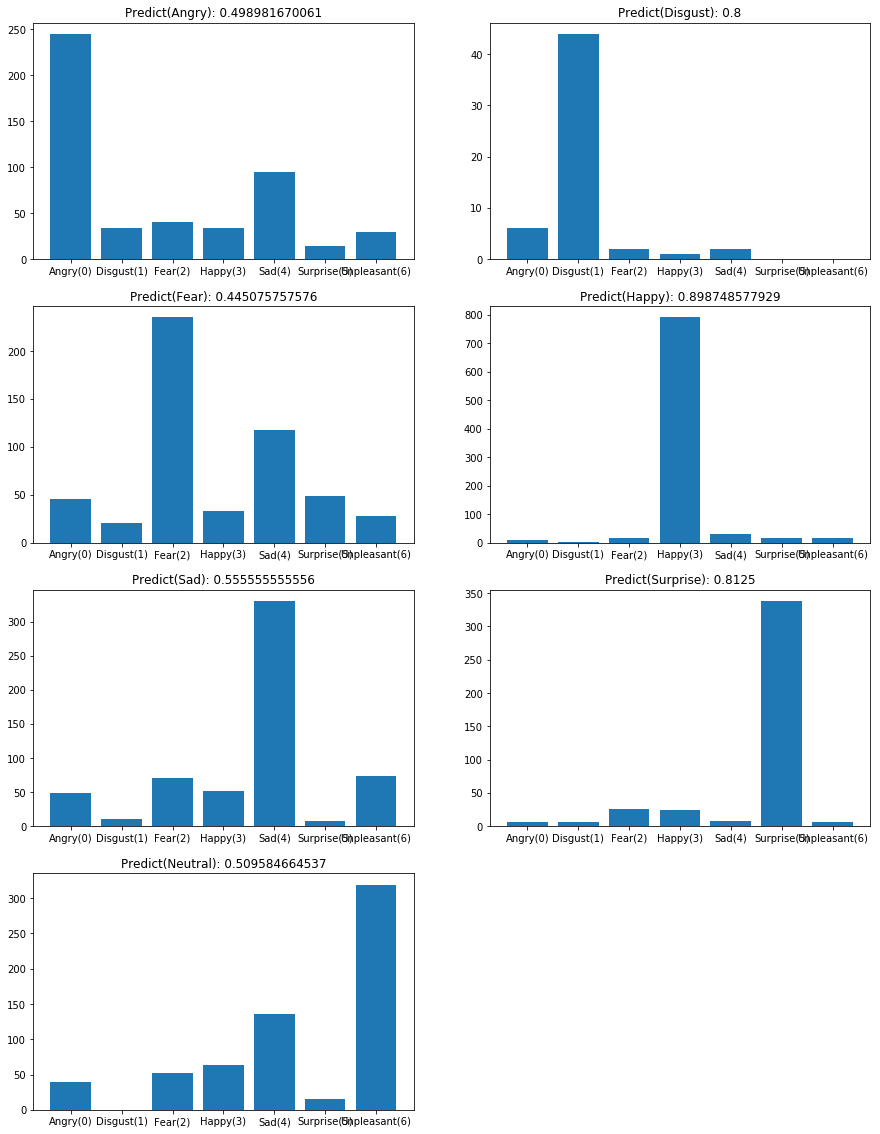

In [213]:
plt.figure(figsize=(15, 20))
res = [dfRes_0, dfRes_1, dfRes_2, dfRes_3, dfRes_4, dfRes_5, dfRes_6]
title = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
acc_li = [acc0, acc1, acc2, acc3, acc4, acc5, acc6]
x = [0, 1, 2, 3, 4, 5, 6]

for i in range(len(res)):
    plt.subplot(4, 2, (i+1))
    y = []

    for j in range(7):
        y.append((res[i]['pred1'] == j).sum())
        
    plt.bar(left=x, height=y)
    plt.xticks(x, ['Angry(0)', 'Disgust(1)', 'Fear(2)', 'Happy(3)', 'Sad(4)', 'Surprise(5)', 'Unpleasant(6)'])
    plt.title('Predict({}): {}'.format(title[i], acc_li[i]))

plt.show()